In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from matplotlib.finance import candlestick2_ohlc,candlestick_ohlc
import setuptools
%load_ext cython 
%matplotlib inline

c:\users\administrator\anaconda2\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
DF = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/finance-charts-apple.csv')
from matplotlib import dates, ticker
DF['Date'] = DF['Date'].apply(lambda x : dates.datestr2num(x))

In [3]:
df = DF.iloc[0:50]
arr = df.iloc[:,1:5].values

open_  = arr[:,0]
high_ = arr[:,1]
low_ = arr[:,2]
close_ = arr[:,3]

def aka_npin(open_,high_,low_,close_,n=3):
    vec = np.full(shape=(open_.shape[0],),fill_value=np.nan)
    for i,val in enumerate(vec):
        if i < n:
            continue
        prev_idx = i-n > 0 and i-n or 0
        all_red = (open_[prev_idx:i] < close_[prev_idx:i]).all() # 每一天都是红色的
        all_close_increase = np.all(np.diff(close_[prev_idx:i]) > 0) # 每一天的收盘价都比前一天的收盘价高，红三兵的特性
        all_great = (np.abs((open_[prev_idx:i] -  close_[prev_idx:i] )/ close_[prev_idx:i]) >= 0.004).all() # 每天实体都
        if all_close_increase and all_red and all_great: 
            vec[i-1] = 1  
    return vec
vec = aka_npin(open_,high_,low_,close_,n=3)

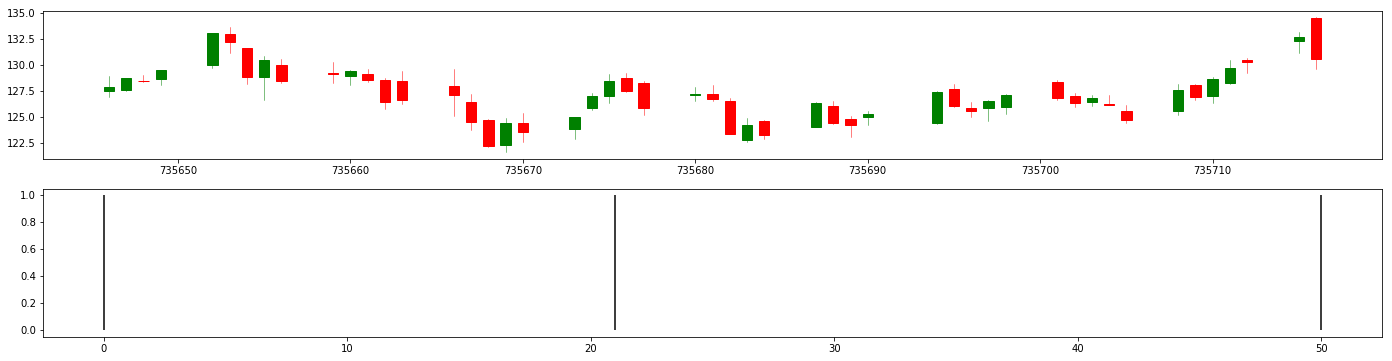

In [4]:
fig = plt.figure(figsize=(24,6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
candlestick_ohlc(ax1, df.values, width=0.6, colorup='green', colordown='red')
li = pd.Series(vec).dropna().index.tolist()
li.insert(0,0)
li.insert(len(li),len(vec))
ax2.vlines(li,0,1)

In [27]:
%%cython 
import numpy as np
cimport numpy as np
from cython.parallel cimport prange
# from libcpp cimport bool

ctypedef fused Dtype_t:
    np.float32_t
    np.float64_t
    np.int32_t
    
ctypedef fused Dtype_s:
    float
    double
    int
    
cpdef np.ndarray[Dtype_t] aka_npin_core(np.ndarray[Dtype_t] open_
               ,np.ndarray[Dtype_t] high_
               ,np.ndarray[Dtype_t] low_
               ,np.ndarray[Dtype_t] close_
               ,Dtype_s n=3
               ):
    cdef int i 
    cdef Dtype_s prev_idx
    cdef np.ndarray[Dtype_t] vec
    cdef np.ndarray[Dtype_t] m_close
    cdef np.ndarray[Dtype_t] m_open
    cdef bint all_red
    cdef bint all_close_increase
    cdef bint all_great
    
    vec = np.full(shape=(open_.shape[0],),fill_value=np.nan)
    for i in range(len(vec)):
        if i < n:
            continue
        prev_idx = i-n > 0 and i-n or 0
        m_close =  close_[prev_idx:i]
        m_open =  open_[prev_idx:i]
        all_red = (m_open < m_close).all() # 每一天都是红色的
        all_close_increase = np.all(np.diff(m_close) > 0) # 每一天的收盘价都比前一天的收盘价高，红三兵的特性
        all_great = (np.abs((m_open -  m_close )/ m_close) >= 0.004).all() # 每天实体都
        if all_close_increase and all_red and all_great: 
            vec[i-1] = 1  
    return vec

cpdef aka_npin(np.ndarray[Dtype_t,ndim=2] arr_open
               ,np.ndarray[Dtype_t,ndim=2] arr_high
               ,np.ndarray[Dtype_t,ndim=2] arr_low
               ,np.ndarray[Dtype_t,ndim=2] arr_close
               ,Dtype_s n=3):
    cdef np.ndarray[Dtype_t,ndim=2] arr_res
    cdef np.ndarray[Dtype_t] vec_open
    cdef np.ndarray[Dtype_t] vec_high
    cdef np.ndarray[Dtype_t] vec_low
    cdef np.ndarray[Dtype_t] vec_close
    cdef np.ndarray[Dtype_t] vec

    arr_res = np.full_like(arr_open,fill_value=np.nan)
    
    if not arr_open.shape == arr_high.shape and arr_open.shape == arr_low.shape and arr_open.shape == arr_close.shape:
        raise AssertionError()
    for i in range(arr_open.shape[1]):
        vec_open = arr_open[:,i]
        vec_high = arr_high[:,i] 
        vec_low = arr_low[:,i] 
        vec_close = arr_close[:,i] 
#         arr_res[:,i] = aka_npin_core [np.float32_t,np.float32_t,np.float32_t,np.float32_t,int] (vec_open,vec_high,vec_low,vec_close,n)
        vec = aka_npin_core(vec_open,vec_high,vec_low,vec_close,n=n)
        arr_res[:,i] = vec
    return arr_res

c:\users\administrator\anaconda2\lib\site-packages\Cython\Compiler\Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: C:\Users\Administrator\.ipython\cython\_cython_magic_102bd497e73a8cb35e697aa8962f8bd4.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [28]:
vec = aka_npin_core(open_,high_,low_,close_,n=3)

In [29]:
vec

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,   1.,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan])

In [29]:
%timeit aka_npin_core(open_,high_,low_,close_,n=3)

1000 loops, best of 3: 1.06 ms per loop


In [33]:
df_ = df.iloc[:,1:5]
df_.values.dtype


dtype('float64')

In [32]:
%timeit aka_npin(df_.values,df_.values,df_.values,df_.values)

100 loops, best of 3: 4.35 ms per loop


,Date,AAPL.Open,AAPL.High,AAPL.Low,AAPL.Close,AAPL.Volume,AAPL.Adjusted,dn,mavg,up,direction
0,735646.0,127.489998,128.880005,126.919998,127.830002,63152400,122.905254,106.741052,117.927667,129.114281,Increasing
1,735647.0,127.629997,128.779999,127.449997,128.720001,44891700,123.760965,107.842423,118.940333,130.038244,Increasing
2,735648.0,128.479996,129.029999,128.330002,128.449997,37362400,123.501363,108.894245,119.889167,130.884089,Decreasing
3,735649.0,128.619995,129.500000,128.050003,129.500000,48948400,124.510914,109.785449,120.763500,131.741551,Increasing
4,735652.0,130.020004,133.000000,129.660004,133.000000,70974100,127.876074,110.372516,121.720167,133.067817,Increasing
5,735653.0,132.940002,133.600006,131.169998,132.169998,69228100,127.078049,111.094869,122.664834,134.234798,Decreasing
6,735654.0,131.559998,131.600006,128.149994,128.789993,74711700,123.828261,113.211918,123.629667,134.047415,Decreasing
7,735655.0,128.789993,130.869995,126.610001,130.419998,91287500,125.395469,114.165299,124.282333,134.399367,Increasing
8,735656.0,130.000000,130.570007,128.240005,128.460007,62014800,123.510987,114.966848,124.842667,134.718485,Decreasing
9,735659.0,129.250000,130.279999,128.300003,129.089996,48096700,124.116706,115.877090,125.403667,134.930243,Decreasing
